<a href="https://colab.research.google.com/github/tengkumuazabs/my-portfolio/blob/main/python-projects/covid-cxr/Copy_of_Hybrid_CNN_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

In [46]:
from keras.applications import InceptionV3, ResNet50
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [47]:
# Define dataset paths and classes
data_path = '/content/drive/MyDrive/COVIDGR_1.0'
categories = ['N', 'P']

In [48]:
# Function to load images and labels
def load_images(data_path, categories):
    images = []
    labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        for filename in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, filename))
            img = cv2.resize(img, (224, 224))  # Resize to 224x224 pixels
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [49]:
# Load dataset
images, labels = load_images(data_path, categories)

In [50]:
images.shape

(852, 224, 224, 3)

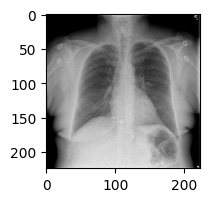

In [51]:
plt.figure(figsize=(2,2))
plt.imshow(images[0])

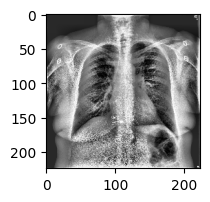

In [52]:
# Enhance image with CLAHE technique
def clahe(image):
    clahe = cv2.createCLAHE()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

images_clahe = np.array([clahe(img) for img in images])

plt.figure(figsize=(2,2))
plt.imshow(images_clahe[0])

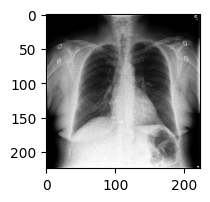

In [53]:
# Enhance image with HE technique
def he(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

images_he = np.array([he(img) for img in images])

plt.figure(figsize=(2,2))
plt.imshow(images_he[0])

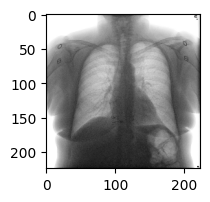

In [54]:
# Enhance image with Bitwise technique
def bitwise(image):
    return cv2.bitwise_not(image)

images_bitwise = np.array([bitwise(img) for img in images])

plt.figure(figsize=(2,2))
plt.imshow(images_bitwise[0])

<ipython-input-55-d5071ca829e9>:12: RuntimeWarning: overflow encountered in scalar multiply
  bnum = Lmax * Lmax *(Gmean-Gmin) - LMssum*(Gmax-Gmin) + Lmin * Lmin *(Gmax-Gmean)
<ipython-input-55-d5071ca829e9>:13: RuntimeWarning: overflow encountered in scalar multiply
  bden = 2*(Lmax*(Gmean-Gmin)-Lmean*(Gmax-Gmin)+Lmin*(Gmax-Gmean))
<ipython-input-55-d5071ca829e9>:17: RuntimeWarning: overflow encountered in scalar add
  a = (Gmax-Gmin)/((Lmax-Lmin)*(Lmax+Lmin-2*b))


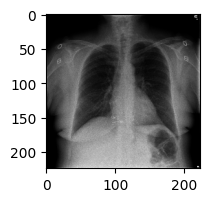

In [55]:
# Enhance image with BCET technique
def bcet(image):
    Lmin = np.min(image) # MINIMUM OF INPUT IMAGE
    Lmax = np.max(image) # MAXIMUM OF INPUT IMAGE
    Lmean = np.mean(image) #MEAN OF INPUT IMAGE
    LMssum = np.mean(image * image) #MEAN SQUARE SUM OF INPUT IMAGE

    Gmin = 0 #MINIMUM OF OUTPUT IMAGE
    Gmax = 255 #MAXIMUM OF OUTPUT IMAGE
    Gmean = 100 #MEAN OF OUTPUT IMAGE

    bnum = Lmax * Lmax *(Gmean-Gmin) - LMssum*(Gmax-Gmin) + Lmin * Lmin *(Gmax-Gmean)
    bden = 2*(Lmax*(Gmean-Gmin)-Lmean*(Gmax-Gmin)+Lmin*(Gmax-Gmean))

    b = bnum/bden

    a = (Gmax-Gmin)/((Lmax-Lmin)*(Lmax+Lmin-2*b))

    c = Gmin - a*(Lmin-b) * (Lmin-b)

    y = a*(image-b) * (image-b) +c #PARABOLIC FUNCTION
    y = np.array(y, dtype=np.uint8)

    return y

images_bcet = np.array([bcet(img) for img in images])

plt.figure(figsize=(2,2))
plt.imshow(images_bcet[0])

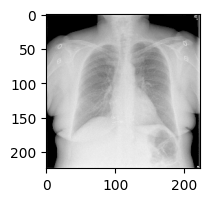

In [56]:
# Enhance image with Gamma technique
def gamma(image, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(image, table)

images_gamma = np.array([gamma(img, 2.2) for img in images])

plt.figure(figsize=(2,2))
plt.imshow(images_gamma[0])

In [57]:
# Define CNN model for feature extraction
inceptionv3 = InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [58]:
# Define classifier for classification
svm_linear = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')

In [59]:
# Cross validation function for extraction and classification
def train_and_evaluate_model(images, labels, cnn_model, clf):
  images_features = cnn_model.predict(images / 255)
  images_features_flatten = images_features.reshape(images_features.shape[0], -1)

  scores = cross_val_score(clf, images_features_flatten, labels, cv=2, scoring='accuracy')

  print(f'Score: {scores}')
  print(f'Mean Score: {scores.mean()}')
  print('\n')

In [16]:
# Dictionary for every images, CNN models, and classifiers
images_dict = {
    'images': images,
    'images_clahe': images_clahe,
    'images_gamma': images_gamma,
    'images_he': images_he
}

cnn_dict = {
    'inceptionv3': inceptionv3,
    'resnet50': resnet50
}

clf_dict = {
    'svm_linear': svm_linear,
    'svm_rbf': svm_rbf
}

In [55]:
# Repeated cross validation for every combination from the dictionaries
for key, image in images_dict.items():
  for key2, cnn_model in cnn_dict.items():
    for key3, clf in clf_dict.items():
      print(f'{key} - {key2} - {key3}')
      train_and_evaluate_model(image, labels, cnn_model, clf)

images - inceptionv3 - svm_linear
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Score: [0.70657277 0.69248826]
Mean Score: 0.6995305164319249


images - inceptionv3 - svm_rbf
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Score: [0.69248826 0.71126761]
Mean Score: 0.7018779342723005


images - resnet50 - svm_linear
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
Score: [0.63849765 0.66197183]
Mean Score: 0.6502347417840375


images - resnet50 - svm_rbf
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
Score: [0.54929577 0.57981221]
Mean Score: 0.5645539906103287


images_clahe - inceptionv3 - svm_linear
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
Score: [0.66431925 0.6713615 ]
Mean Score: 0.6678403755868545


images_clahe - inceptionv3 - svm_rbf
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Score: [0.68779343 0.69248826]
Mean Score: 0.6901408450704225


images_clahe - resnet50 - svm_linear
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
Score: [0.61267606 0.65258216]
Mean Score: 0.6326291079812206


images_clahe - resnet50 - svm_rbf


In [67]:
for key, image in images_dict.items():
  for key2, cnn_model in cnn_dict.items():
    for key3, clf in clf_dict.items():
      print(f'{key} - {key2} - {key3}')
      train_and_evaluate_model(image, labels, cnn_model, clf)

images_he - inceptionv3 - svm_linear
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
Score: [0.67840376 0.67840376]
Mean Score: 0.6784037558685446


images_he - inceptionv3 - svm_rbf
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
Score: [0.70657277 0.69248826]
Mean Score: 0.6995305164319249


images_he - resnet50 - svm_linear
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
Score: [0.61032864 0.68544601]
Mean Score: 0.647887323943662


images_he - resnet50 - svm_rbf
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
Score: [0.61502347 0.62206573]
Mean Score: 0.6185446009389671




In [60]:
# Best combination: Gamma + InceptionV3 + SVM RBF
images_gamma_features = inceptionv3.predict(images_gamma / 255)
images_gamma_features_flatten = images_gamma_features.reshape(images_gamma_features.shape[0], -1)

svm_rbf.fit(images_gamma_features_flatten, labels)

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step


SVC()

In [27]:
# Save trained model
joblib.dump(svm_rbf, 'best_model.pkl')

['best_model.pkl']

In [61]:
# Testing with new images (16 Negatives + 16 Positives)
# Define test image paths and classes
data_path = '/content/drive/MyDrive/COVIDGR_1.0/Test Images'
categories = ['N', 'P']

In [62]:
# Load dataset
images_test, labels_test = load_images(data_path, categories)

In [63]:
images_test.shape

(32, 224, 224, 3)

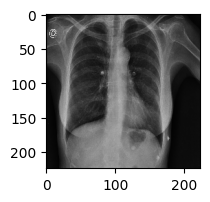

In [64]:
plt.figure(figsize=(2,2))
plt.imshow(images_test[0])

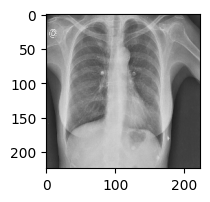

In [65]:
images_test_gamma = np.array([gamma(img, 2.2) for img in images_test])

plt.figure(figsize=(2,2))
plt.imshow(images_test_gamma[0])

In [66]:
# Extact test image features
images_test_features = inceptionv3.predict(images_test_gamma / 255)
images_test_features_flatten = images_test_features.reshape(images_test_features.shape[0], -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [ ]:
# Predict test image
prediction = svm_rbf.predict(images_test_features_flatten)

In [ ]:
# Print accuracy score
accuracy_score(prediction, labels_test)

0.625

In [69]:
# Using best combination without Gamma
images_features = inceptionv3.predict(images / 255)
images_features_flatten = images_features.reshape(images_features.shape[0], -1)

svm_rbf.fit(images_features_flatten, labels)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


SVC()

In [70]:
# Extact test image features
images_test_features = inceptionv3.predict(images_test / 255)
images_test_features_flatten = images_test_features.reshape(images_test_features.shape[0], -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [ ]:
# Predict test image
prediction = svm_rbf.predict(images_test_features_flatten)

In [ ]:
# Print accuracy score
accuracy_score(prediction, labels_test)

0.5